# Target variables

TBD on lookup horizon - lookup over 1s candles instead of ticks to speed up


1. simple up/down signal
2. up/down/put where put would be either tails of distribution (moves less than 10th centile or greater than 90th)
3. actual up/down values in pips
4. up/down price movements transformed into 7 buckets of uniform distribution


# Features

Analytics across different candle resolutions such as 1min, 5min, 10min, 15min, 30min

gap value div prev 30days’ avg, median, 95th centile + time lag up to 5 periods
gap rank in the prev months gap + time lag up to 5 periods

last 10 candles how many down, how many up
last 5 candles size compared to: prev month mean, median, 95th centile

MA_{candleSize}_{period}_diff  + lag of 5
MA_{candleSize}_{period}_diff normalised by pervious month’s values + lag of 5

In [6]:
import featureeng as feng
import data.readers as rd
import time
import warnings
from warnings import simplefilter
from featureeng.features import *
import numpy as np
from numba import jit

import time


# Define a custom function to apply over the rolling window

@jit(nopython=True)
def f(window):
    pips = 10000
    # Ensure there are enough data points in the window
    if len(window) != 3:
        return np.nan

    #if increasing
    if window[2][2] - window[0][2] > 0:
        return (window[2][1] - window[0][0]) * pips
    else:
        return (window[0][1] - window[2][0]) * pips
    #if mid-point-to-mid-point is decreasing, then calc gap by C1.L-C3.H
    #Otherwise C3.L-C1.H


def fill_data(df):
    df['close'] = df['close'].ffill()
    df['close'] = df['close'].bfill()
    
    df['midPoint'] = df['midPoint'].ffill()
    df['midPoint'] = df['midPoint'].bfill()
    
    df['Spread'] = df['Spread'].ffill()
    df['Spread'] = df['Spread'].bfill()
    return df

# Feature engineering

1. Load the data
2. For a given candle resolution
    1. Look within a defined time
    2. 

In [39]:
# 1. Load data for all years
# 2. b-fill f-fill for a given candle resolution (i.e. 10min)
# 3. gap cals
# 4. select sub-sample - 7:00 - 17:00

def trim_outliers(data, column_name):
    p1 = data[column_name].quantile(0.001)
    p99 = data[column_name].quantile(0.999)
    data[column_name+"_trimmed"] = data[column_name].apply(lambda x: max(min(x, p99), p1))
    
    return data

def prep_data(instrument='EURGBP', candle_size='10min', year=None):
    #1. Load data
    start_time = time.time()
    ticks = rd.read_in_ticks('/data', instrument, year=year)
    end_time = time.time()
    print(f'Loaded data in: {end_time - start_time:.3f} seconds')

    start_time = time.time()
    ticks =fill_data(process_df_count(ticks, candle_size))
    end_time = time.time()
    print(f'b-fill, f-fill in: {end_time - start_time:.3f} seconds')
    
    start_time = time.time()
    # Apply the custom function over a rolling window of size 3 with raw=True
    ticks['gap'] = ticks[['high', 'low', 'midPoint']].rolling(3, method='table').apply(f, raw=True, engine='numba')['high']
    
    ticks = trim_outliers(ticks, 'gap')
    
    # Print the DataFrame
    end_time = time.time()
    print(f'Gap calculation in: {end_time - start_time:.3f} seconds')
    return ticks.between_time('07:00', '19:00')


result_10min = prep_data()
#result_1s = prep_data(candle_size='1s')

EURGBP - /data
/data/EURGBP
Loaded data in: 13.498 seconds
b-fill, f-fill in: 37.221 seconds
Gap calculation in: 0.068 seconds


Analytics across different candle resolutions such as 1min, 5min, 10min, 15min, 30min

gap value div prev 30days’ avg, median, 95th centile + time lag up to 5 periods gap rank in the prev months gap + time lag up to 5 periods

last 10 candles how many down, how many up; last 5 candles size compared to: prev month mean, median, 95th centile

MA_{candleSize}{period}diff + lag of 5 MA{candleSize}{period}_diff normalised by pervious month’s values + lag of 5

In [93]:
import itertools


result_10min = result_10min.dropna(subset=["open"])
result_10min.reset_index(drop=True, inplace=True)

def prep_features(data, window=600, quantiles=[0.50, 0.95, 0.99]):
    for quantile in quantiles:
        data[f'gap_q{int(quantile*100)}']=data['gap'].rolling(window=window).quantile(quantile)
        data[f'gap_trimmed_q{int(quantile*100)}']=data['gap_trimmed'].rolling(window=window).quantile(quantile)
        data[f'gap_div_gap_q{int(quantile*100)}']=data['gap']/data[f'gap_q{int(quantile*100)}']
        
    return data

def candle_size_feats(data, windows=[3, 5, 10, 20]):
    data['open_minus_close'] = (data['open']-data['close'])*10000
    for window in windows:
        data[f'negative_count_{window}'] = data['open_minus_close'].rolling(window=window).apply(lambda x: (x>0).sum(), raw=True)
        data[f'positive_count_{window}'] = data['open_minus_close'].rolling(window=window).apply(lambda x: (x<0).sum(), raw=True)
    
    for pair in list(itertools.combinations(windows, 2)):
        w1 = pair[0]
        w2 = pair[1]
        data[f'negative_count_{w1}_div_negative_count_{w2}'] = data[f'negative_count_{w1}'] / data[f'negative_count_{w2}']
        data[f'positive_count_{w1}_div_positive_count_{w2}'] = data[f'positive_count_{w1}'] / data[f'positive_count_{w2}']
        
    return data

def lag_features(data, col_names, lag):
    
    return data

temp_res_10min = prep_features(result_10min)
temp_res_10min = candle_size_feats(temp_res_10min)

In [94]:
temp_res_10min

,open,high,low,close,midPoint,Count,Spread,gap,gap_trimmed,gap_q95,...,negative_count_5_div_negative_count_10,positive_count_5_div_positive_count_10,negative_count_20,positive_count_20,negative_count_3_div_negative_count_20,positive_count_3_div_positive_count_20,negative_count_5_div_negative_count_20,positive_count_5_div_positive_count_20,negative_count_10_div_negative_count_20,positive_count_10_div_positive_count_20
0,0.900995,0.901100,0.900870,0.901055,0.900985,709,0.692525,-1.25,-1.25,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.901065,0.901130,0.900680,0.900730,0.900905,1088,0.830515,-3.00,-3.00,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.900720,0.900755,0.900350,0.900425,0.900552,1076,0.649071,1.15,1.15,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.900435,0.900705,0.900380,0.900615,0.900543,1239,0.584181,-0.25,-0.25,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.900610,0.900615,0.899720,0.899790,0.900168,1913,0.845949,-2.65,-2.65,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77312,0.876595,0.876865,0.876530,0.876710,0.876698,1569,0.611918,-2.00,-2.00,3.1125,...,0.800000,0.20,10.0,10.0,0.200000,0.100000,0.400000,0.100000,0.500000,0.500000
77313,0.876715,0.876905,0.876675,0.876905,0.876790,1054,0.701518,-3.20,-3.20,3.1125,...,0.600000,0.40,10.0,10.0,0.100000,0.200000,0.300000,0.200000,0.500000,0.500000
77314,0.876895,0.876965,0.876790,0.876815,0.876877,918,0.683007,-0.75,-0.75,3.1125,...,0.500000,0.50,11.0,9.0,0.090909,0.222222,0.272727,0.222222,0.545455,0.444444
77315,0.876825,0.877055,0.876755,0.876940,0.876905,1533,0.602805,-1.50,-1.50,3.1125,...,0.333333,0.75,11.0,9.0,0.090909,0.222222,0.181818,0.333333,0.545455,0.444444


Index(['open', 'high', 'low', 'close', 'midPoint', 'Count', 'Spread', 'gap',
       'gap_trimmed', 'gap_q95', 'gap_trimmed_q95', 'gap_q99',
       'gap_trimmed_q99', 'gap_q75', 'gap_trimmed_q75', 'gap_q50',
       'gap_trimmed_q50', 'gap_div_gap_q50', 'gap_div_gap_q95',
       'gap_div_gap_q99', 'open_minus_close', 'negative_count_5',
       'positive_count_5', 'negative_count_10', 'positive_count_10'],
      dtype='object')
Skewness: 0.39182914721473305
Mean: -0.34548787446933255, 
 Median: -0.3573622201128037, 
 Standard Deviation: 0.5180600697125455
 Variance: 0.26838623583056753
Kurtosis: 7.087932501295247
IQR: 0.5721087403318463, Q1: -0.6412862960581904, Q3: -0.06917755572634415, P1: -1.6111487632112647, P99: 1.0207036294523344


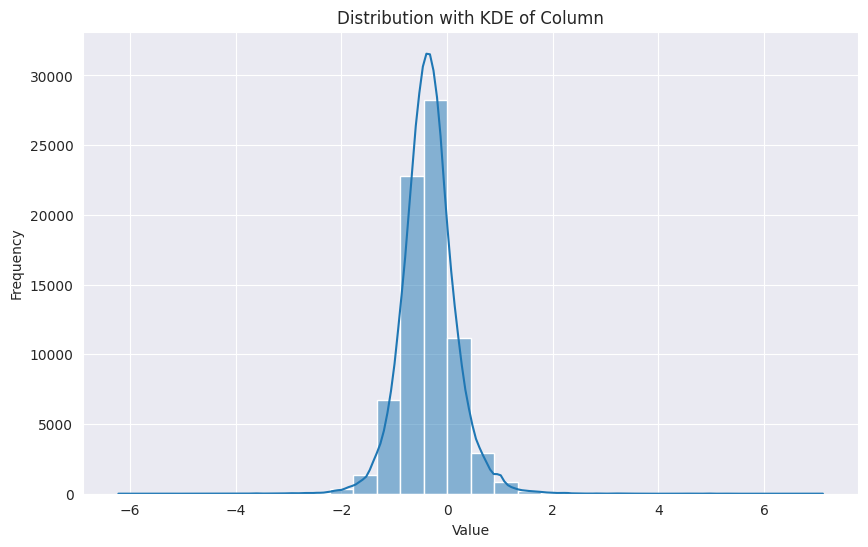

In [86]:
print(temp_res_10min.columns)

analysis(temp_res_10min, col_name='gap_div_gap_q99')

Skewness: -3.2478384316010107
Mean: -2.452299898479916, 
 Median: -2.3000000000000798, 
 Standard Deviation: 0.9144198809217353
 Variance: 0.8361637186249207
Kurtosis: 16.445235946700407
IQR: 0.8500000000000174, Q1: -2.7500000000002522, Q3: -1.9000000000002348, P1: -6.575000000000886, P99: -1.2499999999993072


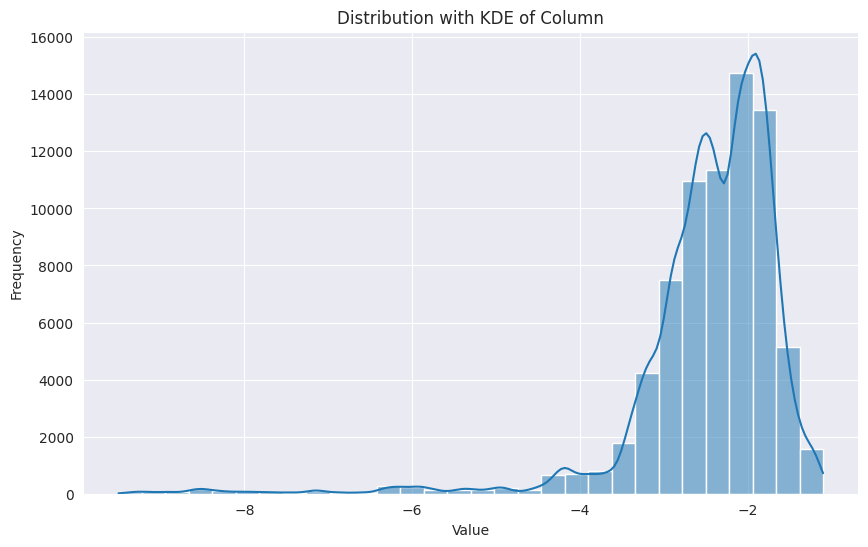

In [76]:
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats

def analysis(df_full, start=None, end=None, col_name='close'):
    from scipy import stats
    import seaborn as sns
    import matplotlib.pyplot as plt
    
    if start and end:
        df = df_full[start:end]
    else:
        df = df_full
    # Sample DataFrame and column
    # df = pd.DataFrame({'column_name': [...your data...]})
    
    # Basic Statistics
    mean = df[col_name].mean()
    median = df[col_name].median()
    std_dev = df[col_name].std()
    kurtosis = df[col_name].kurt()
    variance = df[col_name].var()
    
    # Interquartile Range
    Q1 = df[col_name].quantile(0.25)
    Q3 = df[col_name].quantile(0.75)
    P1 = df[col_name].quantile(0.01)
    P99 = df[col_name].quantile(0.99)
    IQR = Q3 - Q1
    
    skewness = df[col_name].skew()
    print(f"Skewness: {skewness}")
    print(f"Mean: {mean}, \n Median: {median}, \n Standard Deviation: {std_dev}\n Variance: {variance}")
    print(f"Kurtosis: {kurtosis}")
    print(f"IQR: {IQR}, Q1: {Q1}, Q3: {Q3}, P1: {P1}, P99: {P99}")

    plt.figure(figsize=(10, 6))
    sns.histplot(df[col_name], kde=True, bins=30)
    plt.title('Distribution with KDE of Column')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.show()

def show_qq(df, col_name, dist):
    stats.probplot(df[col_name], dist=dist, sparams=(1,), plot=plt)


    plt.title('Q-Q Plot')
    plt.ylabel('Observed Quantiles')
    plt.xlabel('Theoretical Quantiles')
    # Show the plot
    plt.show()

analysis(temp_res_10min, col_name='gap_q50')
#show_qq(df=temp_res_10min, col_name='gap_q95', dist='norm')


1. simple up/down signal
2. up/down/put where put would be either tails of distribution (moves less than 10th centile or greater than 90th)
3. actual up/down values in pips
4. up/down price movements transformed into 7 buckets of uniform distribution

In [26]:
def prep_targets(data):
    pass


features_10min = prep_features(result_10min)
features_targets = prep_targets(result_1s)

In [27]:
result_1s.tail()

,open,high,low,close,midPoint,Count,Spread,gap
DateTime,,,,,,,,
2023-01-27 18:59:56,0.877030,0.877040,0.877030,0.877040,0.877035,5,0.40,-0.05
2023-01-27 18:59:57,0.877035,0.877045,0.877030,0.877045,0.877037,9,0.40,-0.10
2023-01-27 18:59:58,0.877040,0.877050,0.877040,0.877050,0.877045,5,0.36,0.00
2023-01-27 18:59:59,0.877040,0.877040,0.877035,0.877035,0.877038,2,0.45,-0.10
2023-01-27 19:00:00,0.877040,0.877045,0.877040,0.877045,0.877043,2,0.45,-0.05


In [28]:
#test

In [29]:
#def

In [30]:
#test